Epoch 1/20
24/24 [==============================] - 8s 204ms/step - loss: 1.0405 - accuracy: 0.4453 - val_loss: 1.0139 - val_accuracy: 0.4243
Epoch 2/20
24/24 [==============================] - 3s 106ms/step - loss: 0.8645 - accuracy: 0.6189 - val_loss: 0.8260 - val_accuracy: 0.6432
Epoch 3/20
24/24 [==============================] - 4s 157ms/step - loss: 0.6183 - accuracy: 0.7351 - val_loss: 0.8126 - val_accuracy: 0.6486
Epoch 4/20
24/24 [==============================] - 5s 213ms/step - loss: 0.4264 - accuracy: 0.8453 - val_loss: 0.8396 - val_accuracy: 0.6514
Epoch 5/20
24/24 [==============================] - 2s 104ms/step - loss: 0.2501 - accuracy: 0.9149 - val_loss: 0.8977 - val_accuracy: 0.6730
Epoch 6/20
24/24 [==============================] - 3s 105ms/step - loss: 0.1558 - accuracy: 0.9432 - val_loss: 0.9859 - val_accuracy: 0.6676
Epoch 7/20
24/24 [==============================] - 2s 104ms/step - loss: 0.1083 - accuracy: 0.9716 - val_loss: 1.1616 - val_accuracy: 0.6432
Epoch 

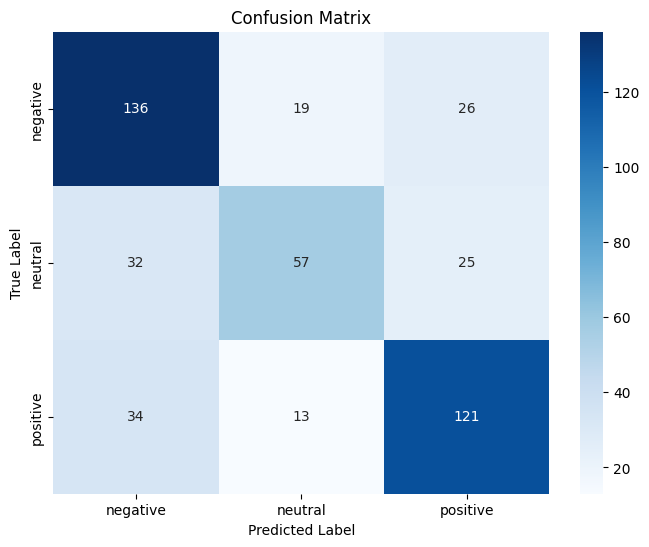

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Input
from tensorflow.keras.models import Model
from keras.layers import concatenate

# Load the dataset
df = pd.read_csv('/content/Laptop_datasets.csv')  # Replace 'dataset.csv' with your dataset file

# Preprocessing the dataset
text_data = df['text'].values
aspect_data = df['aspect'].values
label_data = df['label'].values

# Map labels to numerical values
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
label_data = np.array([label_mapping[label] for label in label_data])

# Split the dataset into training and testing sets
text_train, text_test, aspect_train, aspect_test, label_train, label_test = train_test_split(
    text_data, aspect_data, label_data, test_size=0.2, random_state=42
)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
vocab_size = len(tokenizer.word_index) + 1

text_train_seq = tokenizer.texts_to_sequences(text_train)
text_test_seq = tokenizer.texts_to_sequences(text_test)

# Pad sequences for equal length
max_sequence_length = max(max(len(seq) for seq in text_train_seq), max(len(seq) for seq in text_test_seq))
text_train_seq = pad_sequences(text_train_seq, maxlen=max_sequence_length)
text_test_seq = pad_sequences(text_test_seq, maxlen=max_sequence_length)

# Tokenize the aspect data
aspect_tokenizer = Tokenizer()
aspect_tokenizer.fit_on_texts(aspect_train)
aspect_vocab_size = len(aspect_tokenizer.word_index) + 1

aspect_train_seq = aspect_tokenizer.texts_to_sequences(aspect_train)
aspect_test_seq = aspect_tokenizer.texts_to_sequences(aspect_test)

# Pad sequences for equal length
max_aspect_length = max(max(len(seq) for seq in aspect_train_seq), max(len(seq) for seq in aspect_test_seq))
aspect_train_seq = pad_sequences(aspect_train_seq, maxlen=max_aspect_length)
aspect_test_seq = pad_sequences(aspect_test_seq, maxlen=max_aspect_length)

# Create the model
embedding_dim = 100
hidden_units = 128

text_input = Input(shape=(max_sequence_length,))
aspect_input = Input(shape=(max_aspect_length,))

text_embedding = Embedding(vocab_size, embedding_dim)(text_input)
aspect_embedding = Embedding(aspect_vocab_size, embedding_dim)(aspect_input)

text_gru = GRU(hidden_units)(text_embedding)
aspect_gru = GRU(hidden_units)(aspect_embedding)

combined = concatenate([text_gru, aspect_gru])
output = Dense(3, activation='softmax')(combined)

model = Model(inputs=[text_input, aspect_input], outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 20

model.fit([text_train_seq, aspect_train_seq], label_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Predict on the test set
predictions = model.predict([text_test_seq, aspect_test_seq])
predictions = np.argmax(predictions, axis=1)

# Compute evaluation metrics
precision = precision_score(label_test, predictions, average='macro')
recall = recall_score(label_test, predictions, average='macro')
f1 = f1_score(label_test, predictions, average='macro')
accuracy = accuracy_score(label_test, predictions)

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
print('Accuracy:', accuracy)

# Compute the confusion matrix
cm = confusion_matrix(label_test, predictions)
class_names = ['negative', 'neutral', 'positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
